In [1]:
from pypetri.elements import *
from pypetri.petri_net import *
from pypetri.example_nets import *
import math

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random

from tqdm import tqdm


In [2]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self):
        return len(self.buffer)
        

In [3]:
class N2N(nn.Module):
    def __init__(self, dim_in, dim_out, f=F.leaky_relu):
        super(N2N, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        x = self.f(x)
        return x
    
class T2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(T2P, self).__init__()
        # self.adj_pt = torch.from_numpy(adj_pt).float()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, x):
        x = torch.matmul(self.adj_pt, x)
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        x = self.f(x)
        return x
        
class PConcat(nn.Module):
    def __init__(self, dim_in, dim_out, f=F.leaky_relu):
        super(PConcat, self).__init__()
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x, dx):
        x = torch.cat((x, dx), dim=-1)
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        x = self.f(x)
        return x
        
class P2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(P2T, self).__init__()
        # self.adj_pt = torch.from_numpy(adj_pt).float()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x):
        x = torch.matmul(self.adj_pt.t(), x)
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        x = self.f(x)
        return x
        

In [4]:
class GPNQNet(torch.nn.Module):
    def __init__(self, lp0, lt0, adj_matrix, device):
        super(GPNQNet, self).__init__()
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        
        self.P2P_1 = N2N(lp0, 8)
        self.T2T_1 = N2N(lt0, 8)
        self.T2P_1 = T2P(8, 8, self.adj_matrix)
        self.PCat2 = PConcat(16, 16)
        self.P2T_2 = P2T(16, 16, self.adj_matrix)
        self.T2P_2 = T2P(16, 16, self.adj_matrix)
        self.PCat3 = PConcat(32, 32)
        self.P2T_3 = P2T(32, 8, self.adj_matrix)
        self.T2T_f = N2N(8, 1)
        

    def forward(self, p, t):
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p).float()
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).float()
        p1 = self.P2P_1(p)
        t1 = self.T2T_1(t)
        
        dp1 = self.T2P_1(t1)
        p2 = self.PCat2(p1, dp1)
        t2 = self.P2T_2(p2)
        
        dp2 = self.T2P_2(t2)
        p3 = self.PCat3(p2, dp2)
        t3 = self.P2T_3(p3)
        tf = self.T2T_f(t3)
        
        return tf
        

In [5]:
class DQN:
    def __init__(self, lp, lt, action_dim, adj_matrix, learning_rate, gamma, epsilon, target_update, device):
        self.lp = lp
        self.lt = lt
        self.action_dim = action_dim
        self.q_net = GPNQNet(lp, lt, adj_matrix, device).to(device)
        self.target_q_net = GPNQNet(lp, lt, adj_matrix, device).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        self.count = 0
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, self.action_dim)
        else:
            state_p = state[0]
            state_l = state[1]
            state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
            state_l = torch.tensor([state_l], dtype=torch.float).to(self.device)
            action = self.q_net(state_p, state_l).argmax().item()
        return action
        
    def update(self, transition_dict):
        # print(transition_dict['states'][:, 0])
        p_states = torch.tensor([transition_dict['states'][:, 0]], dtype=torch.float).squeeze(0).to(self.device)
        t_states = torch.tensor([transition_dict['states'][:, 1]], dtype=torch.float).squeeze(0).to(self.device)
        
        actions = torch.tensor([transition_dict['actions']]).view(-1, 1).unsqueeze(-1).to(self.device)
        rewards = torch.tensor([transition_dict['rewards']], dtype=torch.float).view(-1, 1).to(self.device)
        
        next_p_states = torch.tensor([transition_dict['next_states'][:, 0]], dtype=torch.float).squeeze(0).to(self.device)
        next_t_states = torch.tensor([transition_dict['next_states'][:, 1]], dtype=torch.float).squeeze(0).to(self.device)
        dones = torch.tensor([transition_dict['dones']], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(p_states, t_states)
        q_values = q_values.gather(1, actions)
        max_next_q_values = self.target_q_net(next_p_states, next_t_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        loss = torch.mean(F.mse_loss(q_values, q_targets))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [6]:

lr = 1e-3
gamma = 0.98
epsilon = 0.05
num_episode = 500
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64

efm_net = EmptyNet('efm_net')
initial_file_path = 'initial_file/neural_petri_net.csv'
efm_net.init_by_csv(initial_file_path)
efm_net.set_dt(1)

lp = efm_net.get_state()[0].shape[1]
lt = efm_net.get_state()[1].shape[1]
action_dim = efm_net.get_action_space()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(lp, lt, action_dim, efm_net.get_adj_matrix(), lr, gamma, epsilon, target_update, device)

cuda


In [7]:

return_list = []
action_list = []
for i in range(50):
    with tqdm(total=int(num_episode / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episode / 10)):
            episode_return = 0
            state = efm_net.reset()
            done = False
            this_action = []
            
            while not done:
                action = agent.take_action(state)
                this_action.append(action)
                next_state, reward, done = efm_net.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state

                episode_return += reward

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'rewards': b_r, 'next_states': b_ns, 'dones': b_d}
                    agent.update(transition_dict)

                if efm_net.train_time > 100:
                    done = True
                        
                    
            action_list.append(this_action)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episode / 10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\87903\AppData\Local\Temp\ipykernel_31892\491946403.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
Iteration 0:   8%|▊         | 4/50 [00:02<00:20,  2.24it/s]C:\Users\87903\AppData\Local\Temp\ipykernel_31892\846506765.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state), action, reward, np.array(next_state), done
C:\Users\87903\AppData\Local\Temp\ipykernel_31892\491946403.py:42: UserWarning: Using a tar

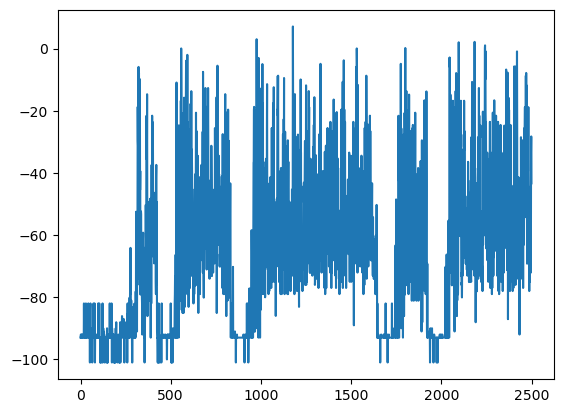

In [9]:
# print(return_list)
plt.plot(range(len(return_list)), return_list)

In [16]:
import csv

result_path = 'result0914.csv'

with open(result_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(return_list)

In [21]:
import importlib
from rltk import rl_utils

importlib.reload(rl_utils)

<module 'rltk.rl_utils' from 'e:\\SJTU_pro\\DigitalTwin\\dtg_ws\\pntk\\rltk\\rl_utils.py'>

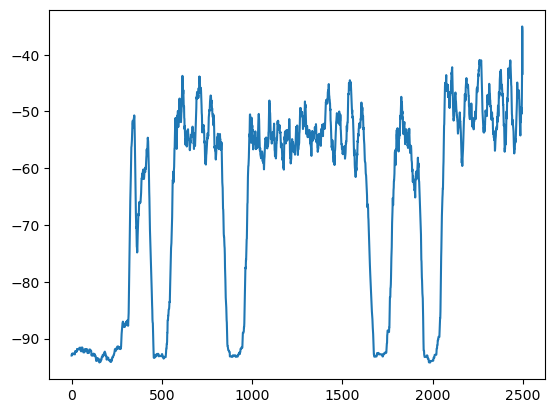

In [25]:
mv_return = rl_utils.window_average(return_list, 32)
plt.plot(range(len(return_list)), mv_return)

In [27]:
print(len(action_list[-20]))
print(action_list[-20])

101
[50, 50, 50, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 51, 50, 50, 26, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 51, 51, 51, 51, 51, 52, 19, 52, 0, 52, 52, 30, 52, 52, 52, 52, 52, 16, 52, 51, 17, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 52, 18, 50, 52, 52, 52, 52, 52, 52, 0, 0]


In [31]:
print(return_list[-20:])

[-39.39999999999999, -24.69, -18.830000000000016, -29.499999999999993, -35.44000000000001, -50.29, -49.299999999999976, -78.00999999999999, -57.22, -51.11, -75.03999999999999, -44.48999999999996, -50.28999999999998, -46.32999999999998, -61.18, -64.15000000000002, -72.07, -33.46000000000004, -28.260000000000016, -43.36000000000003]
